# Creating a ML model to predict median house prices in California

Main steps in a ML project

1. Frame the problem
2. Exploring the data with visualization
3. Prepare the data for ML/AI
4. Develop an ML model and predict
5. Check the results with various statistical tests
6. Fine tune and optimize

In [1]:
import sklearn
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True)

In [2]:
pwd = os.getcwd()
filepath = os.path.join(pwd, "housing.csv")

# Reading in the data

In [3]:
raw_df = pd.read_csv(filepath)

Take a brief look at the head of the df

In [4]:
raw_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We need to explore the data, take a brief look at the columns and their data-types

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that we have 10 columns, where 9 of them are floats and 1 string. We can see that we do not have any date column, so we keep the default index. Taking a closer look at the text index, the categorical variable.

In [6]:
raw_df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

We can see that there are 9k houses located at less than 1H from the Ocean, and only 5 on an island. Lets visualize the data in a horizontal barchart

<AxesSubplot:>

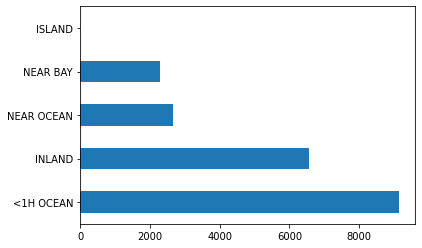

In [7]:
raw_df["ocean_proximity"].value_counts().plot(kind = "barh")

Taking a closer look at the numerical features with the describe method.

In [8]:
raw_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


We can see that there are some missing data in the total_bedrooms colum, but not a significant number. Furthermore, we can see that the median income is 3.9, and furthermore that the median house value, which we are going to predict, is 206k USD.

Checking out median income feature, with a histogram

<AxesSubplot:>

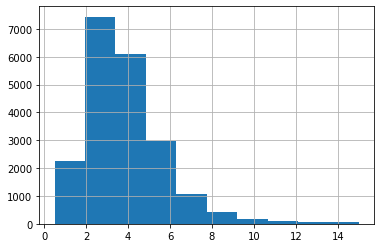

In [9]:
raw_df["median_income"].hist()

The data needs a bit more granular representation, so i decide to put them into 5 bins, into a new category, which i call income_bin.

In [10]:
raw_df["income_bin"] = pd.cut(x = raw_df["median_income"], bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])

In [11]:
raw_df["income_bin"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_bin, dtype: int64

<AxesSubplot:>

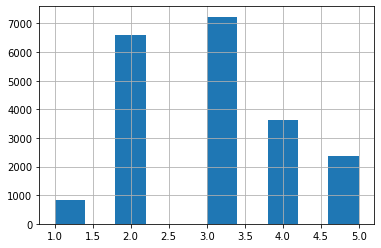

In [12]:
raw_df["income_bin"].hist()

# Preparing the ML model

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
y = raw_df["median_house_value"]
x = raw_df.drop("median_house_value", axis = 1)

Making sure that the shapes of the features and values are correct

In [15]:
x.shape

(20640, 10)

In [16]:
y.shape

(20640,)

Splitting up the data into train and test set, where i set the test size to be 25%

In [17]:
x_train, y_train, x_test, y_test = train_test_split(x, y, test_size = 0.25)

We need to make sure that the distribution across the income bin column is approximately even, so the model learns the mapping across different categories.

In [18]:
x_train["income_bin"].value_counts()

3    5389
2    4902
4    2749
5    1832
1     608
Name: income_bin, dtype: int64

It looks decent, but we can make sure it is by using a stratified split. Approximate percentages of income bin is evenly distributed.

# Creating a stratified split

In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

In [20]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in split.split(raw_df, raw_df["income_bin"]):
    strat_train_set = raw_df.loc[train_index]
    strat_test_set = raw_df.loc[test_index]

In [21]:
strat_train_set["income_bin"].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_bin, dtype: float64

In [22]:
raw_df["income_bin"].value_counts() / len(raw_df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_bin, dtype: float64

We can see that the distribution of the stratified train set is quite similar to the overall distribution. This makes sure the splitting is done correctly and we dont have a bias when training. We no longer need the income bin feature anymore, since it is more of an data exploration feature we created to check the distribution of values. It is basically just a bin version of another feature.

In [23]:
strat_train_set.drop("income_bin", axis = "columns", inplace = True)
strat_test_set.drop("income_bin", axis = "columns", inplace = True)

We have now prepared the dataframes which we will use in predictions

In [24]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,240200.0,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,113000.0,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,97800.0,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,225900.0,<1H OCEAN


In [25]:
strat_test_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,500001.0,<1H OCEAN
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,240300.0,<1H OCEAN
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,218200.0,<1H OCEAN
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,182100.0,INLAND
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,121300.0,INLAND
...,...,...,...,...,...,...,...,...,...,...
20519,-121.53,38.58,33.0,4988.0,1169.0,2414.0,1075.0,1.9728,76400.0,INLAND
17430,-120.44,34.65,30.0,2265.0,512.0,1402.0,471.0,1.9750,134000.0,NEAR OCEAN
4019,-118.49,34.18,31.0,3073.0,674.0,1486.0,684.0,4.8984,311700.0,<1H OCEAN
12107,-117.32,33.99,27.0,5464.0,850.0,2400.0,836.0,4.7110,133500.0,INLAND


# Visualizing the data

We should not look at the test set, should only visualize the train set. This is to avoid overfitting.

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

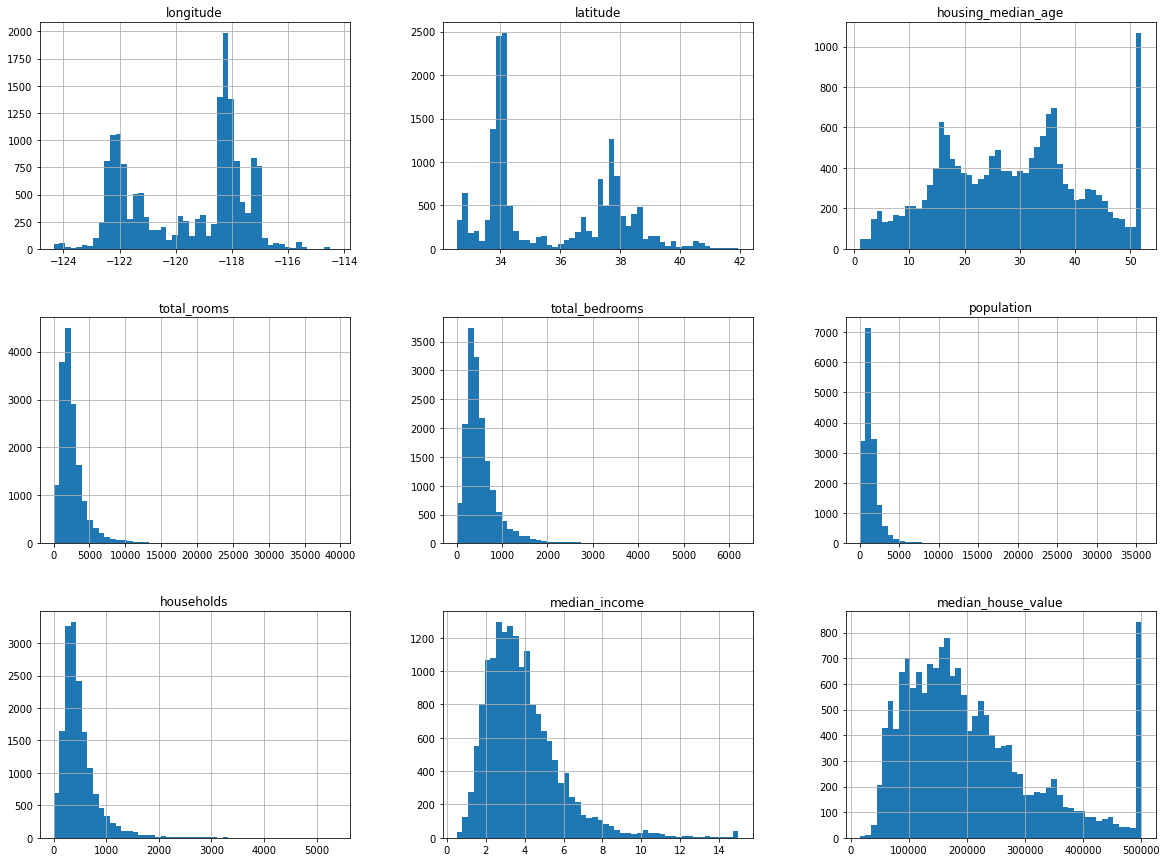

In [26]:
strat_train_set.hist(bins = 50, figsize = (20, 15))

We can see that there are some grouped values, especially in the age feature, and the median house value feature. We see that the largest number of observation in both of these are far to the right in the histogram. We can further see that the other features are right skewed, which matches what exists in reality. Some have extreme wealth.

<AxesSubplot:>

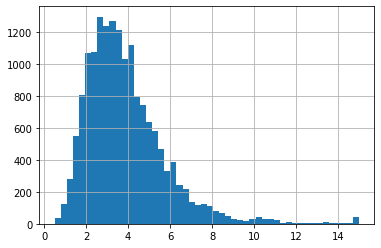

In [27]:
strat_train_set["median_income"].hist(bins = 50)

Taking a look at the geographic data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

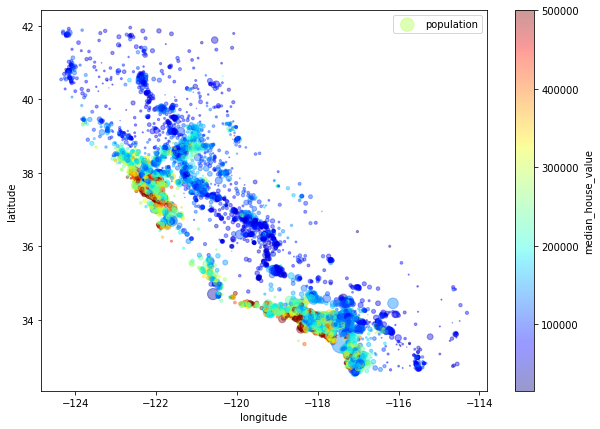

In [28]:
strat_train_set.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = strat_train_set["population"] / 100, label = "population", figsize = (10, 7), c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True, sharex=False)

Could rather use plotly, tableau or powerBI vs plotly, they are much better for visualization. We want to take a look at the correlation between the different features in our data, and visualize it. We can therefore use a sns heatmap.

In [29]:
corr = strat_train_set.corr()

<AxesSubplot:>

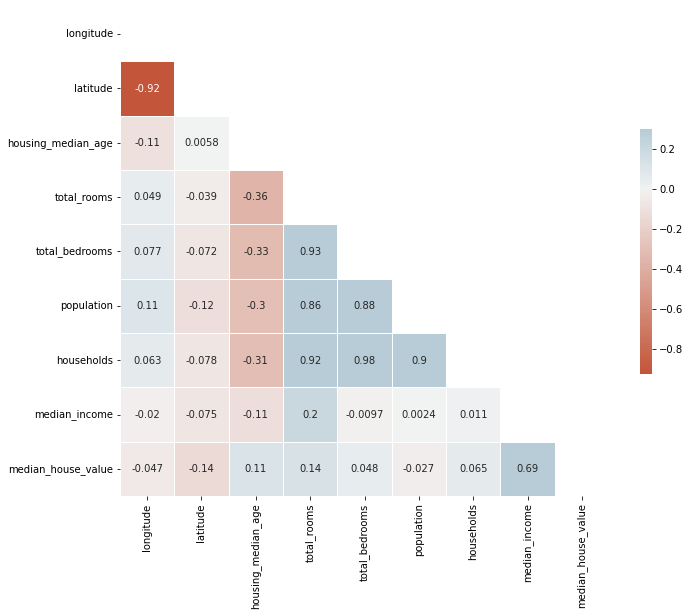

In [30]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize = (11, 9))
cmap = sns.diverging_palette(20, 230, as_cmap=True) 
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 0.3, center = 0, square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5}, annot = True)

We can see that the median income feature is around 0.7 correlated with the median house value, therefore an important feature in predicting the median house value. 

# Feature Engineering

We can also try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. So I have created a simple function that takes care of this feature engineering.

In [31]:
def feature_engineering(data):
    """
    Simple function to include two additional features by combining other features
    """
    data["rooms_per_household"] = data["total_rooms"] / data["households"]
    data["bedrooms_per_room"] = data["total_bedrooms"] / data["total_rooms"]    
    
    return data

# Preparing the data for ML

In [32]:
# dropping the value we are going to predict
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()

Dealing with columns with missing values. total_bedrooms attribute has some missing values, so let’s fix this. We have 3 different options, and we choose to fill with median.

In [33]:
housing.dropna(subset=["total_bedrooms"])
housing.drop("total_bedrooms", axis=1)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

There is a class in sklearn that deals with missing data, so we import this and choose median. Median can only be computed on numerical data, so i create a copy of housing df without the text column.

In [34]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis = True)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [35]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now we can use the trained imputer to transform the training set by replacing missing values with the learned medians.

In [36]:
x = imputer.transform(housing_num)

Transforming this back into a dataframe

In [37]:
housing_tr = pd.DataFrame(x, columns = housing_num.columns, index = housing_num.index)

In [38]:
housing_tr_columns = list(housing_tr.columns)

Dealing with the categorical features, ocean_proximity

In [39]:
housing_cat = housing[["ocean_proximity"]]

In [40]:
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


We see that the ocean_proximity feature is a categorical variable. ML algos prefer to work with numerical data, so convert the categorical variable to numerical

In [41]:
from sklearn.preprocessing import OrdinalEncoder

In [42]:
ordinal_encoder = OrdinalEncoder()

In [43]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

We can see that our different categorical variables have been converted to numerical values. ML algos assumes that two nearby values, 0 and 1, are more similar than two distant values, 0 and 4, but this is not the case here. This can be good for ordinal data, but we are dealing with categorical data. We therefore use one hot encoding instead, giving a value of 1 if it is present and 0 if not. 

In [44]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [46]:
housing_cat_1hot_arr = housing_cat_1hot.toarray()

In [47]:
housing_cat_1hot_arr_columns = list(cat_encoder.categories_[0])

# Scaling the data

We need to scale the numerical features so that the algorithm does not give wrong weights in the fit-transform phase.

In [48]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

housing_num_scaled = scaler.fit_transform(housing_num)

In [49]:
output = np.hstack([housing_num_scaled, housing_cat_1hot_arr])

In [50]:
housing_tr_columns.extend(housing_cat_1hot_arr_columns)

In [51]:
features = housing_tr_columns

In [52]:
output

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

# Function that combines the steps above

In [53]:
def data_transformations(data):
    
    # separate data if existing
    
    if "median_house_value" in data.columns:
        labels = data["median_house_value"]
        data = data.drop("median_house_value", axis = 1)
        
    else:
        None
    
    # feature engineering
    feature_engineered_data = feature_engineering(data)
    features = list(feature_engineered_data.columns)    
    
    # imputing the data
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy="median")
    
    housing_num = feature_engineered_data.select_dtypes(include=[np.number])
    imputed = imputer.fit_transform(housing_num)
    
    # encoding categorical data
    housing_cat = feature_engineered_data.select_dtypes(exclude=[np.number])
    
    from sklearn.preprocessing import OneHotEncoder
    
    cat_encoder = OneHotEncoder(sparse = False)
    
    housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
    features = features + cat_encoder.categories_[0].tolist()

    features.remove("ocean_proximity") # since we have encoded this feature
    
    # scaling numerical data
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    
    housing_scaled = scaler.fit_transform(imputed)
    
    # concatenating data
    output = np.hstack([housing_scaled, housing_cat_1hot])
    
    return output, labels, features


# Calling the function above to return the data prepared for ML

In [54]:
train_data, train_labels, features = data_transformations(strat_train_set)

In [55]:
train_data

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [56]:
test_data, test_labels, features = data_transformations(strat_test_set)

In [57]:
test_data

array([[ 0.57471497, -0.69620912,  0.03285951, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.83839441, -0.86074221,  0.82471029, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.24635944, -0.65390061, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.52496413, -0.66800344,  0.19122966, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.10704893, -0.75732141, -0.12551065, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.31601062,  0.55894333, -0.75899128, ...,  0.        ,
         0.        ,  0.        ]])

# Selecting the linear regression model

In [58]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_data, train_labels)

LinearRegression()

In [59]:
original_values = test_labels
predicted_values = lin_reg.predict(test_data)

In [60]:
comparison_df = pd.DataFrame(data = {"Original Values": original_values, "Predicted Values": predicted_values})
comparison_df["Diff"] = comparison_df["Original Values"] - comparison_df["Predicted Values"]
comparison_df

,Original Values,Predicted Values,Diff
5241,500001.0,431626.270337,68374.729663
10970,240300.0,262450.502099,-22150.502099
20351,218200.0,221364.415059,-3164.415059
6568,182100.0,202950.618445,-20850.618445
13285,121300.0,165368.249318,-44068.249318
...,...,...,...
20519,76400.0,119657.350731,-43257.350731
17430,134000.0,192483.025516,-58483.025516
4019,311700.0,288890.290041,22809.709959
12107,133500.0,194296.591873,-60796.591873


In [61]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(original_values, predicted_values)
lin_rmse = np.sqrt(lin_mse)
print(f"Root mean square error for linear regression algorithm: {lin_rmse:.2f}")

Root mean square error for linear regression algorithm: 66798.98


# Decision tree algorithm

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)
tree_reg.fit(train_data, train_labels)

DecisionTreeRegressor(random_state=42)

In [63]:
original_values = test_labels
predicted_values = tree_reg.predict(test_data)

In [64]:
comparison_df = pd.DataFrame(data = {"Original Values": original_values, "Predicted Values": predicted_values})
comparison_df["Diff"] = comparison_df["Original Values"] - comparison_df["Predicted Values"]
comparison_df

,Original Values,Predicted Values,Diff
5241,500001.0,500001.0,0.0
10970,240300.0,190700.0,49600.0
20351,218200.0,205900.0,12300.0
6568,182100.0,184200.0,-2100.0
13285,121300.0,231100.0,-109800.0
...,...,...,...
20519,76400.0,82400.0,-6000.0
17430,134000.0,134600.0,-600.0
4019,311700.0,216900.0,94800.0
12107,133500.0,142600.0,-9100.0


In [65]:
tree_mse = mean_squared_error(original_values, predicted_values)
tree_rmse = np.sqrt(tree_mse)
print(f"Root mean square error for decision tree algorithm: {tree_rmse:.2f}")

Root mean square error for decision tree algorithm: 79542.12


# Random forest algo

In [66]:
from sklearn.ensemble import RandomForestRegressor

In [67]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(train_data, train_labels)

original_values = test_labels
predicted_values = forest_reg.predict(test_data)

In [68]:
forest_mse = mean_squared_error(original_values, predicted_values)
forest_rmse = np.sqrt(forest_mse)
print(f"Root mean square error for random forest algorithm: {forest_rmse:.2f}")

Root mean square error for random forest algorithm: 54104.53


# Closing remarks

It looks like the random forest algorithm produced the best results, with a root mean square error of 54k. This is quite a lot error for a model like this, and I could have taken steps to improve the model further. However, this will be done at a later stage, for now I would want to work through the other problems in the Hands on ML book.